**Importation des bibliothèques**

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

print("Bibliothèques chargées avec succès !")

Bibliothèques chargées avec succès !


**Chargement du Dataset**

In [ ]:
import kagglehub

# Download latest version
dataset_path = kagglehub.dataset_download("iarunava/cell-images-for-detecting-malaria")

print("Path to dataset files:", dataset_path)

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=(32, 32),
    batch_size=32,
    class_mode='binary',
    subset='training',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=(32, 32),
    batch_size=64,
    class_mode='binary',
    subset='validation',
    shuffle=False
)

Using Colab cache for faster access to the 'cell-images-for-detecting-malaria' dataset.
Path to dataset files: /kaggle/input/cell-images-for-detecting-malaria
Found 44093 images belonging to 1 classes.
Found 11023 images belonging to 1 classes.


**Afficher une image du Dataset**

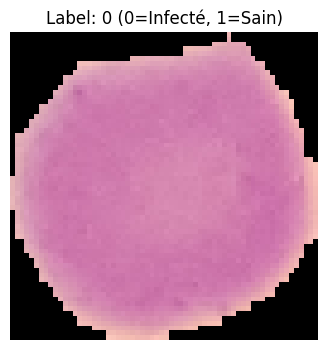

Classes :  {'cell_images': 0}


In [ ]:
images, labels = next(train_gen)
plt.figure(figsize=(4,4))
plt.imshow(images[0])
plt.title(f"Label: {int(labels[0])} (0=Infecté, 1=Sain)")
plt.axis('off')
plt.show()

print("Classes : ", train_gen.class_indices)

**Création du Modèle (CNN)**

In [ ]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 203,905 (796.50 KB)

 Trainable params: 203,905 (796.50 KB)

 Non-trainable params: 0 (0.00 B)

**Entraînement du Modèle**

In [ ]:
# Le surveillant (Callback)
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', # Surveille l'erreur
    patience=2,         # Si pas d'amélioration pendant 2 époques...
    restore_best_weights=True # ... on s'arrête et on garde le meilleur résultat
)

history = model.fit(
    train_gen,
    epochs=10, # On met 10, mais il s'arrêtera avant si c'est suffisant !
    validation_data=val_gen,
    callbacks=[early_stop] # On active le surveillant
)

Epoch 1/10
1378/1378 ━━━━━━━━━━━━━━━━━━━━ 360s 261ms/step - accuracy: 1.0000 - loss: 1.5134e-39 - val_accuracy: 1.0000 - val_loss: 1.5658e-38
Epoch 2/10
1378/1378 ━━━━━━━━━━━━━━━━━━━━ 377s 258ms/step - accuracy: 1.0000 - loss: 1.2069e-40 - val_accuracy: 1.0000 - val_loss: 1.5658e-38
Epoch 3/10
1378/1378 ━━━━━━━━━━━━━━━━━━━━ 350s 254ms/step - accuracy: 1.0000 - loss: 6.7584e-39 - val_accuracy: 1.0000 - val_loss: 1.5658e-38


**Graphe de comparaison**

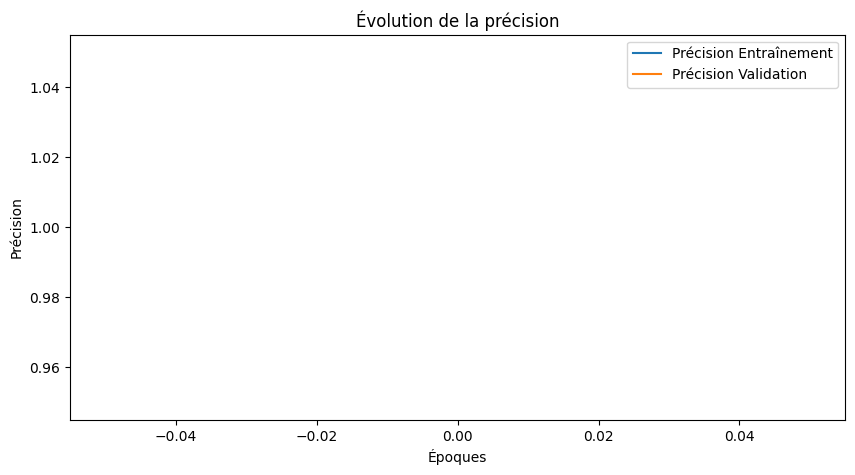

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Précision Entraînement')
plt.plot(history.history['val_accuracy'], label='Précision Validation')
plt.title('Évolution de la précision')
plt.xlabel('Époques')
plt.ylabel('Précision')
plt.legend()
plt.show()

**Matrice de Confusion**

345/345 ━━━━━━━━━━━━━━━━━━━━ 38s 109ms/step


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


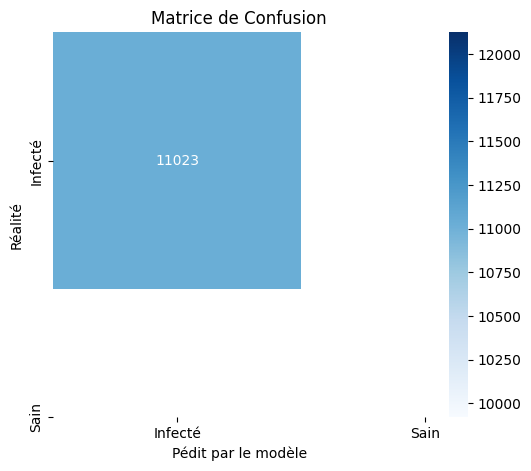

In [ ]:
Y_pred = model.predict(val_gen)
y_pred = (Y_pred > 0.5).astype(int)

cm = confusion_matrix(val_gen.classes, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Infecté', 'Sain'],
            yticklabels=['Infecté', 'Sain'])
plt.xlabel('Pédit par le modèle')
plt.ylabel('Réalité')
plt.title('Matrice de Confusion')
plt.show()

**Afficher les cellules détectées comme "Malaria"**

Voici des exemples de cellules que le modèle a classé comme INFECTÉES (Malaria) :


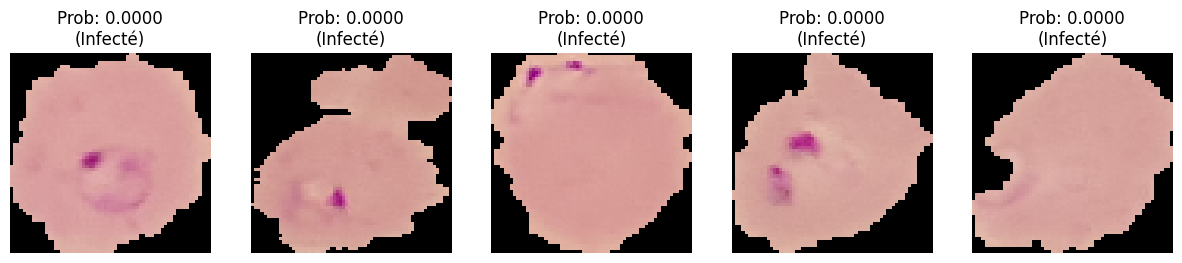

In [ ]:
infected_indices = [i for i, x in enumerate(y_pred) if x == 0]

plt.figure(figsize=(15, 5))
print("Voici des exemples de cellules que le modèle a classé comme INFECTÉES (Malaria) :")

batch_images, _ = next(val_gen)

count = 0
for i in range(len(batch_images)):
    if Y_pred[i] < 0.5:
        ax = plt.subplot(1, 5, count + 1)
        plt.imshow(batch_images[i])
        plt.title(f"Prob: {Y_pred[i][0]:.4f}\n(Infecté)")
        plt.axis("off")
        count += 1
        if count == 5: break

plt.show()